# An NLP analysis based on twitter hash tags

### Objectives:



    *Create new KPI metrics from the tweets
    *Perform sentiment analysis
    *Find out the key words
    *Finding out the words that co-occur

### Twitter NLP:

    *Twitter is a microblogging website where people post messages known as tweets.
    *People often use twitter to communicate their ideas/intentions in a span of 60 words.
    *Lot of the corporates, political parties use twitter as a medium for their work.
        

## Setting up the environment

In [9]:
!pip install -r requirements.txt

Processing /home/vishnu/.cache/pip/wheels/d2/a9/f5/c15e21ba1de8e37bdbd98e177ede3a1cff5d9f3b491a2d267c/pandas_explode-0.0.6-py2.py3-none-any.whl
  Using cached DateTime-4.3-py2.py3-none-any.whl (60 kB)
  Using cached vaderSentiment-3.2.1-py2.py3-none-any.whl (125 kB)
  Using cached tweepy-3.8.0-py2.py3-none-any.whl (28 kB)
  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Using cached numpy-1.16.4.zip (5.1 MB)
  Using cached natsort-6.0.0-py2.py3-none-any.whl (36 kB)
  Using cached nltk-3.4.1.zip (3.1 MB)
  Using cached wordcloud-1.5.0.tar.gz (215 kB)
  Using cached matplotlib-3.2.0-cp38-cp38-manylinux1_x86_64.whl (12.4 MB)
     |████████████████████████████████| 30.7 MB 462 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.0 MB 650 kB/s eta 0:00:01
     |████████████████████████████████| 23.4 MB

In [28]:
pip install seaborn --user

     |████████████████████████████████| 225kB 259kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
import pandas as pd
import numpy as np
import natsort
from collections import OrderedDict
import pandas_explode
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
#import pysentiment as ps
import numpy as np
import datetime
import itertools
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
#!python -m spacy download en
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import spacy

#import counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
pandas_explode.patch()
import seaborn as sns
from nltk.corpus import sentiwordnet as swn, wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/venugopal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/venugopal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/venugopal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/venugopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class TwitterClient():
    def __init__(self):
        consumer_key = 'cQoHkgMkF9t5DvJTBiuE6pJ3k'
        consumer_secret = 'rS6sJLZKQ7HyMKmw4hzRbRQU7x8FIG39fnjfLgesL3XhovYOtM'
        access_token = '1373599392381435905-B2hL9isoAeuDzDh3pzef1Nz6u2DeD2'
        access_token_secret = 'XS65IlJtQMTo6biwdiufANR2Fp2gcw71xQm7QFyqxVkX2'
        self._df = pd.DataFrame(columns=['text', 'source', 'url','Created_at','Location','User','Retweets','Favourites'])
        self._msgs =[]
        self._msg =[]
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth,wait_on_rate_limit=True)
        except:
            print("Error: Authentication Failed")

        
    def get_tweets(self, queries):
        try:
            for query in queries:
                for tweet in tweepy.Cursor(self.api.search, q=query,lang="en",tweet_mode='extended',count=100000).items(100000):
                    if 'retweeted_status' not in dir(tweet):
                        tweet_txt=tweet.full_text
                        tweet_txt=tweet_txt.encode('utf-8')
                        tweet_txt=self.deEmojify(tweet_txt)
                        tweet_txt=tweet_txt.lower()
                        #print tweet_txt
                        self._msg = [self.clean_text(tweet_txt), tweet.source, tweet.source_url,tweet.created_at,tweet.user.location,tweet.user.screen_name,tweet.retweet_count,tweet.favorite_count]#latlong 
                        self._msg = tuple(self._msg)
                        if self._msg not in self._msgs:
                            self._msgs.append(self._msg)

        except tweepy.TweepError as e:
            print("Error : " + str(e))
        self._df = pd.DataFrame(self._msgs,columns=['text', 'source', 'url','Created_at','Location','User','Retweets','Favourites'])
        return self._df
            
    def clean_text(self,text):
        text = re.sub("(n't|N'T)", ' not',                             text) ##Converting n't to Not
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',         text ) ##URLS
        text = re.sub('<.*?>',' ',                                     text ) ##html tags
        text = re.sub(r'[\w\.-]+@[\w\.-]+',r' ',                       text ) ##email addresses
        text = re.sub('\s*\d+\s*',' ',                                 text ) ##Numbers
        text = re.sub(r"\s+", " ",                                     text, flags=re.UNICODE)## remove multiply space and unicode
        text = re.sub(r'&amp'," ",                                     text)
        return text
       
    def deEmojify(self,inputString):
        inputString = str(inputString, errors='replace')
        return inputString.encode('ascii', 'ignore').decode('ascii')

## Input your String 

In [4]:
input_string = input("Enter a hashtag you want in the format #word separated by comma : ")

Enter a hashtag you want in the format #word separated by comma : #Pfizer,#pfizer,#BioNTech,BioNTech,biontech,pfizer,Pfizer


In [5]:
input_string=input_string.lower()
input_list=input_string.split(',')

In [6]:
api = TwitterClient()
tweets = api.get_tweets(input_list)

In [7]:
tweets

,text,source,url,Created_at,Location,User,Retweets,Favourites
0,@inbarcohen they did not work #pfizer,Twitter for Android,http://twitter.com/download/android,2021-03-26 11:39:01,,Apulverma43,0,0
1,@devisridhar yesterday i was told that my yr m...,Twitter for Android,http://twitter.com/download/android,2021-03-26 11:34:43,"London, England",fitzfun2011,0,0
2,"one dose down, one to go! lets do this. #pfizer",Twitter for iPhone,http://twitter.com/download/iphone,2021-03-26 11:34:12,"Louisville, Kentucky",ConorRevell,0,0
3,still not getting this are we people? today's ...,Twitter for Android,http://twitter.com/download/android,2021-03-26 11:26:17,,ditch_crawler,2,1
4,"bill gates chip feckin useless, do you have to...",Twitter for iPhone,http://twitter.com/download/iphone,2021-03-26 11:11:36,Over the hill & far away UK,CourierBoyUK,0,0
5,#covid vaccines should be made mandatory like ...,Twitter for Android,http://twitter.com/download/android,2021-03-26 11:06:22,Nairobi,pauleenmwalo,1,0
6,"""... we wrote privately to them, warning of bl...",Twitter Web App,https://mobile.twitter.com,2021-03-26 10:59:40,"København, Danmark",nbm_1981,0,0
7,dying from the vaccine? @matthancock ? #vaccin...,Twitter for iPhone,http://twitter.com/download/iphone,2021-03-26 10:51:34,London,Chanteldance,0,1
8,@ianhanomansing yes! my mom just got her first...,Twitter for iPhone,http://twitter.com/download/iphone,2021-03-26 10:39:43,,Crackelgirl,0,0
9,@whigman @uk_sf_writer @canderuk @rjsalter @vo...,Twitter for iPad,http://twitter.com/#!/download/ipad,2021-03-26 10:35:46,East Kent,NeilEastell,2,3


In [8]:
tweets['Location']=tweets['Location'].apply(lambda x: "Not specified" if x=='' else x.lower())

## KPIs

#### The main KPIs in this segment:
        1.The related hashtags
        2.The users assosciated
        3.Number of tweets per day
        4.Number of tweets per location

In [9]:
#remove duplicate hashtags
def rem_duplicate_hashtags(df,hash_column):
    hash_list=[]
    for i in df[hash_column]:
        im_list=[]
        for j in i:
            if j not in im_list:
                im_list.append(j)
        hash_list.append(im_list)
    df[hash_column]=hash_list
    return df


#remove  duplicate users
def rem_duplicate_users(df,other_user_column):
    user_list=[]
    for i in df[other_user_column]:
        im_list=[]
        for j in i:
            if j not in im_list:
                im_list.append(j)
        user_list.append(im_list)
    df[other_user_column]=user_list
    return df

def get_kpi_hashtags(df=pd.DataFrame()):
    hash_kpi_dict_list=[]
    df['Other_hash']=np.zeros(len(df))
    df['Other_hash']=df.text.apply(lambda x:["no hashtag"] if not (re.findall(r"[#]\w*",x)) else re.findall(r"[#]\w*",x))
    #print(df['Other_hash'])
    hash_column='Other_hash'
    df=rem_duplicate_hashtags(df,hash_column)
    other_columns=list(df.columns)
    other_columns.remove('Other_hash')
    df=df.explode('Other_hash', axis=1)
    df = df.melt(id_vars=other_columns,value_name='Other_hash')
    df.drop('variable',inplace=True,axis=1)
    top_5_related_hashtags=df['Other_hash'].value_counts()/min(df['Other_hash'].value_counts())
    top_5_related_hashtags=top_5_related_hashtags.to_frame()
    #top_5_related_hashtags=OrderedDict(natsort.natsorted(top_5_related_hashtags.items()))
    return top_5_related_hashtags[0:7]

def get_kpi_users(df=pd.DataFrame()):
    user_kpi_dict_list=[]
    df['Other_user']=np.nan
    df['Other_user']=df.text.apply(lambda x:["no user"] if not (re.findall(r"[@]\w*",x)) else re.findall(r"[@]\w*",x))
    user_column='Other_user'
    df=rem_duplicate_users(df,user_column)
    other_columns=list(df.columns)
    other_columns.remove('Other_user')
    df=df.explode('Other_user', axis=1)
    df = df.melt(id_vars=other_columns,value_name='Other_user')
    df.drop('variable',inplace=True,axis=1)
    top_5_related_users=df['Other_user'].value_counts()/min(df['Other_user'].value_counts())
    top_5_related_users=top_5_related_users[0:7].to_frame()
    return top_5_related_users[0:7]

def get_kpi_tweets(df):
    tweet_kpi_dict_list=[]
    distinct_users={'users':df['User'].nunique()}
    avg_tweets_per_user=float(df.groupby(['User'])['text'].nunique().sum())/len(df.groupby(['User'])['text'].nunique())
    avg_tweets_per_user={"Average No. of tweets per user":avg_tweets_per_user}
    tweets_by_geolocation=df.groupby(['Location'])['text'].nunique().sort_values(ascending=False).to_frame()
    tweet_kpi_dict_list.append(distinct_users)
    tweet_kpi_dict_list.append(avg_tweets_per_user)
    tweet_kpi_dict_list.append(tweets_by_geolocation)
    return tweet_kpi_dict_list

def get_tweets_per_day(df,created_at):
    #df['hour']=np.nan
    df['Date']=df[created_at].apply(lambda x:x.strftime("%Y/%m/%d"))
    #for i in range(len(df)):
     #   df['Date'].iloc[i]=df[created_at].iloc[i].date()
        #df['hour'].iloc[i]=df[created_at].iloc[i].hour
    df=df.groupby(['Date'])['text'].size()
    return df



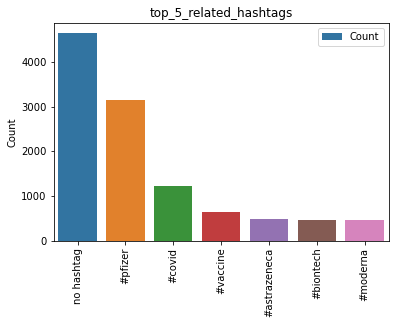

In [10]:
top_5_related_hashtags=get_kpi_hashtags(tweets.copy())
try:
   top_5_related_hashtags=top_5_related_hashtags.drop(input_list)
except:pass

h=sns.barplot(x=list(top_5_related_hashtags.index),y='Other_hash',data=top_5_related_hashtags,label='Count')# only 1 column is passed ie x or y
h.set_xticklabels(rotation=90,labels = list(top_5_related_hashtags.index))
h.set(ylabel = 'Count')
plt.title("top_5_related_hashtags")
h.legend()
plt.show()

                                                                                                                Along with {{input_string}}  the most frequent hashtag is {{top_5_related_hashtags.iloc[0].name}} followed by {{top_5_related_hashtags.iloc[1].name}}.
                                                                                                                
                                                                                                               

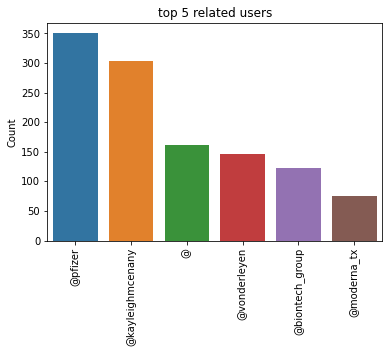

In [11]:
top_5_related_users=get_kpi_users(tweets.copy())
top_5_related_users_old=top_5_related_users
top_5_related_users=top_5_related_users[1:]
h=sns.barplot(x=list(top_5_related_users.index),y='Other_user',data=top_5_related_users,label='Count')# only 1 column is passed ie x or y
h.set_xticklabels(rotation=90,labels = list(top_5_related_users.index))
h.set(ylabel = 'Count')
plt.title("top 5 related users")
#h.legend()
plt.show()

    The author that was most addressed in the tweets was "{{top_5_related_users_old.iloc[0].name}}"  followed by "{{top_5_related_users_old.iloc[1].name}}" and "{{top_5_related_users_old.iloc[2].name}}"
    


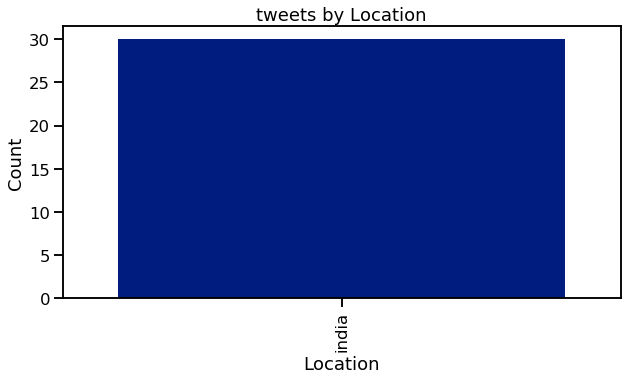

In [129]:
try:
    tweet_kpi_dict_list=get_kpi_tweets(tweets.copy())
    tweet_kpi_dict_list_2_old=tweet_kpi_dict_list[2].loc[tweet_kpi_dict_list[2]['text']>0][:]
    tweet_kpi_dict_list[2]=tweet_kpi_dict_list[2].loc[tweet_kpi_dict_list[2]['text']>20][1:]
    plt.figure(figsize=(10,5))
    ax =sns.barplot(x=list(tweet_kpi_dict_list[2].index),y=tweet_kpi_dict_list[2].text,palette=sns.color_palette('dark'),saturation=1)
    ax.set(ylabel='Count')
    ax.set(xlabel='Location')
    ax.set(title="tweets by Location")
    current_palette = sns.color_palette('dark')
    sns.set_context('talk')
    #sns.palplot(current_palette)
    sns.diverging_palette(255, 133, l=60, n=10, center="dark")
    ax.set_xticklabels(list(tweet_kpi_dict_list[2].index),rotation=90)
    fig = ax.get_figure()
    fig.savefig('tweets_sentiment_positive_per_geo.png',dpi=300, bbox_inches='tight')
except:
       print("Count of tweets less than 20 so no images will be displayed") 
       pass

    Most of the users who tweeted have "{{tweet_kpi_dict_list_2_old.iloc[0].name}}" as their location followed by "{{tweet_kpi_dict_list_2_old.iloc[1].name}}"
    
    The location is what the user specifies hence a lot of spurious data could be found.
    

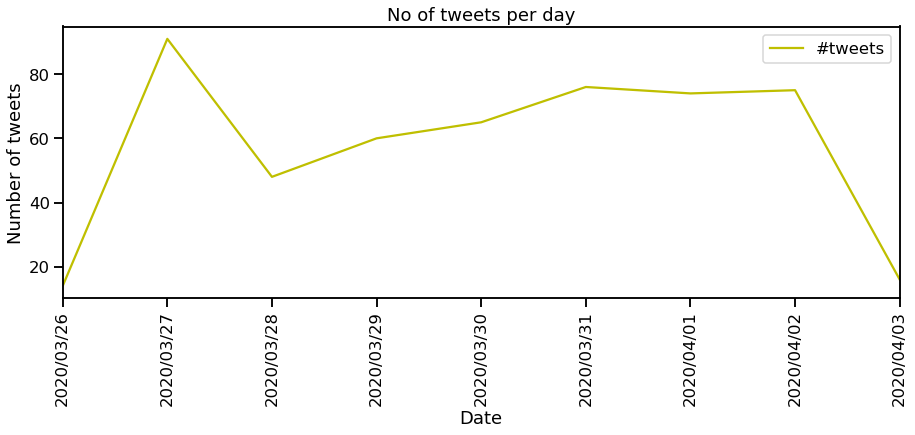

In [130]:
tweets_per_day=get_tweets_per_day(tweets.copy(),'Created_at')
plt.figure(figsize=[15,5])


ax = tweets_per_day.plot('line', rot=90,color='y',label = '#tweets')

plt.ylabel('Number of tweets')
plt.xlabel('Date')
plt.title('No of tweets per day')
plt.legend()
plt.show()


    The steep increase in tweets can be attributed to an event .

## Sentiment Analysis

    Here the sentiment score of the tweets would be calculated and the corresponding tweet will be labelled as         positive,negative or neutral.
    
    The tweets will be pre-processed to remove noise and words that do not have a meaning.
    The tweets are also lemmatized to their root words.
    
    For Sentiment Analysis,Vader and textblob pre-trained models were used.

In [12]:
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(ps.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()

def lemmatize_text(sentence):
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

def TokenizeText(text):
            return [w for s in sent_tokenize(text) for w in word_tokenize(s)]
    
def RemoveStopwords(text, stop_words):
            tokens = [w for w in TokenizeText(text) if w not in stop_words]
            return ' '.join(tokens)


In [13]:
def RemoveOverallNoise(text):
    text = re.sub(r'[@]\w*'," ",                                   text ) ##Authors
    text = re.sub(r'[#]\w*'," " ,                            text ) ##hash tags
    #text = re.sub('\s*\d+\s*',' ',                                 text ) ##Numbers
    text = re.sub('\W+',' ',                                       text ) ##special char
    text = re.sub(r'^[^a-zA-Z]',r' ',                              text ) ##non words
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1',                       text ) ##repetitive words
    text = re.sub(r'\s[a-z]\s|\s[A-Z]\s', " ",                     text ) ##Single word
    
    #' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
    return text

In [19]:
 
#nlp = spacy.load("en")

def preprocess_tweet(df):
    stop_words = set(stopwords.words("english"))
    stop_words.union(STOPWORDS)
    #stop_words.union(nlp.Defaults.stop_words)
    stop_words.remove('not')
    df.Location=df.Location.apply(lambda x: RemoveOverallNoise(x.lower()))
    df.text = df.text.apply(lambda x: RemoveOverallNoise(x.lower()))
    df.text = df.text.apply(lambda x: RemoveStopwords(x.lower(),stop_words))
    df.text = df.text.apply(lambda x: lemmatize_text(x))
    # file = file.drop_duplicates(subset=['text'], keep="first")
    df.to_csv('Cleaned_Tweet.csv',index = False,encoding='utf-8')
    
    return df

In [20]:
tweets_sentiment=preprocess_tweet(tweets.copy())

In [26]:
def vader_sentiment_score(sentence):
    vader = SentimentIntensityAnalyzer()  
    sentiment_dict = vader.polarity_scores(sentence)
    #print (sentiment_dict)
    return sentiment_dict['compound']
def textblob_sentiment_score(sentence): 
    # Create a SentimentIntensityAnalyzer object. 
    textblob_analyzer = TextBlob(sentence)
    textblob_score =  round(textblob_analyzer.sentiment.polarity,2)
    #print (textblob_analyzer.sentiment.polarity)
    return textblob_score

In [27]:
def get_sentiment_score(tweets):
    tweets['Vader_Sentiment_Score']=tweets.text.apply(lambda x:vader_sentiment_score(x))
    tweets['Textblob_Sentiment_Score']=tweets.text.apply(lambda x:textblob_sentiment_score(x))
    tweets['Sentiment_Score']=tweets.text.apply(lambda x:(vader_sentiment_score(x)+textblob_sentiment_score(x))/2)
    return tweets

def get_sentiment_label(Sentiment_Score):
    if  Sentiment_Score ==0.0:
        return 'Neutral'
    elif Sentiment_Score > 0.0:
        return 'Positive'
    elif Sentiment_Score < 0.0:
        return 'Negative'

def get_sentiment(tweets):
    tweets['Sentiment']=tweets['Sentiment_Score'].apply(lambda x:get_sentiment_label(x))
    return tweets

In [23]:
tweets_sentiment=get_sentiment_score(tweets_sentiment)

In [24]:
tweets_sentiment=get_sentiment(tweets_sentiment)

In [139]:
tweets_sentiment.to_csv('tweets_sentiment.csv')

In [140]:
#tweets_sentiment

## Trend Analysis Positive, Negative and Neutral tweets per hour

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


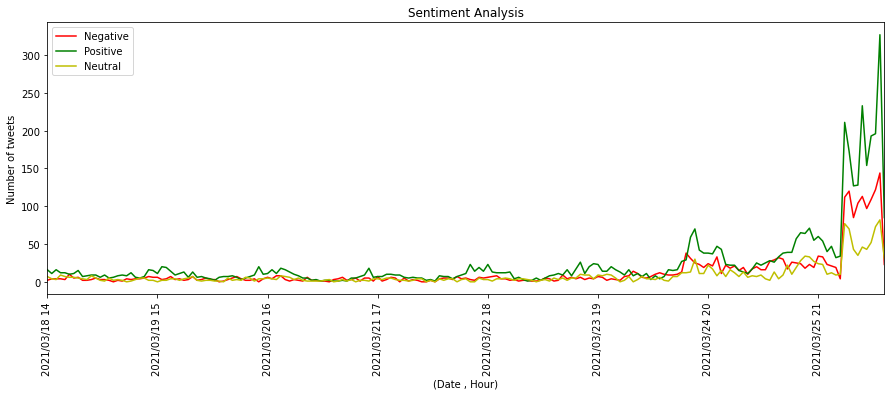

In [28]:
plt.figure(figsize=[15,5])
tweets_sentiment['Date']=tweets_sentiment['Created_at'].apply(lambda x:x.strftime("%Y/%m/%d %H"))
tweets_sentiment_negative_per_hour=tweets_sentiment.groupby(['Date'])['Sentiment'].apply(lambda x: ((x=='Negative')==True).sum())
tweets_sentiment_negative_per_hour.plot('line', rot=90,color = 'red',label='Negative')

tweets_sentiment_positive_per_hour=tweets_sentiment.groupby(['Date'])['Sentiment'].apply(lambda x: ((x=='Positive')==True).sum())
ax=tweets_sentiment_positive_per_hour.plot('line', rot=90,color = 'g',label='Positive')

tweets_sentiment_neutral_per_hour=tweets_sentiment.groupby(['Date'])['Sentiment'].apply(lambda x: ((x=='Neutral')==True).sum())
ax = tweets_sentiment_neutral_per_hour.plot('line', rot=90,color='y',label = 'Neutral')

plt.ylabel('Number of tweets')
plt.xlabel('(Date , Hour)')
plt.title('Sentiment Analysis')
plt.legend()
plt.show()

## +ve , -ve  and Neutral tweets by geolocation

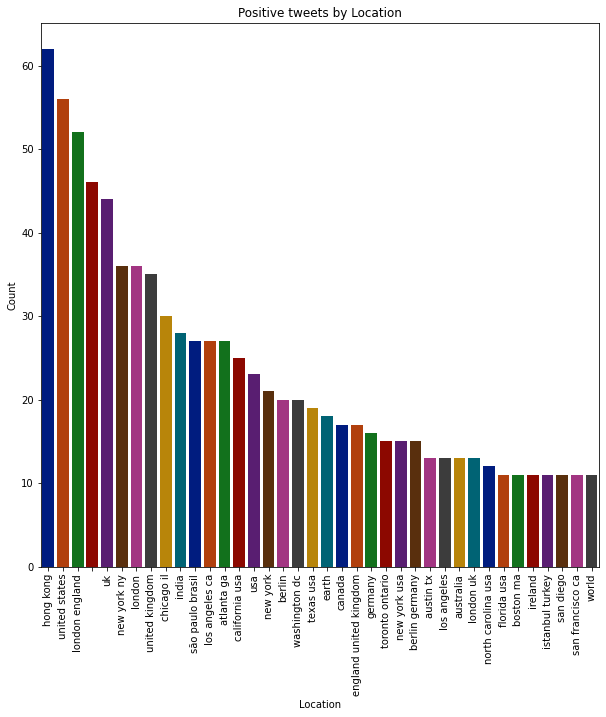

In [29]:
try:
    tweets_sentiment_positive_per_location=tweets_sentiment.groupby(['Location'])['Sentiment'].apply(lambda x: ((x=='Positive')==True).sum())
    tweets_sentiment_positive_per_location =tweets_sentiment_positive_per_location.to_frame() 
    tweets_sentiment_positive_per_location = tweets_sentiment_positive_per_location.sort_values(['Sentiment'],ascending=False).reset_index()
    tweets_sentiment_positive_per_location=tweets_sentiment_positive_per_location.loc[tweets_sentiment_positive_per_location['Sentiment'] > 10]

    plt.figure(figsize=(10,10))
    tweets_sentiment_positive_per_location_old=tweets_sentiment_positive_per_location
    tweets_sentiment_positive_per_location=tweets_sentiment_positive_per_location[1:]
    ax =sns.barplot(x=tweets_sentiment_positive_per_location['Location'],y=tweets_sentiment_positive_per_location.Sentiment,palette=sns.color_palette('dark'),saturation=1)
    ax.set(ylabel='Count')
    ax.set(xlabel='Location')
    ax.set(title="Positive tweets by Location")
    current_palette = sns.color_palette('dark')

    sns.set_context('talk')
    # sns.palplot(current_palette)
    sns.diverging_palette(255, 133, l=60, n=10, center="dark")
    ax.set_xticklabels(tweets_sentiment_positive_per_location.Location,rotation=90)
    fig = ax.get_figure()
    fig.savefig('tweets_sentiment_positive_per_geo.png',dpi=300, bbox_inches='tight')
except:
       print("count of tweets is very less to show the image")
       pass

    The most number of positive tweets came from "{{tweets_sentiment_positive_per_location_old.Location[0]}}" followed by "{{tweets_sentiment_positive_per_location_old.Location[1]}}" and "{{tweets_sentiment_positive_per_location_old.Location[2]}}"   and "{{tweets_sentiment_positive_per_location_old.Location[3]}}".

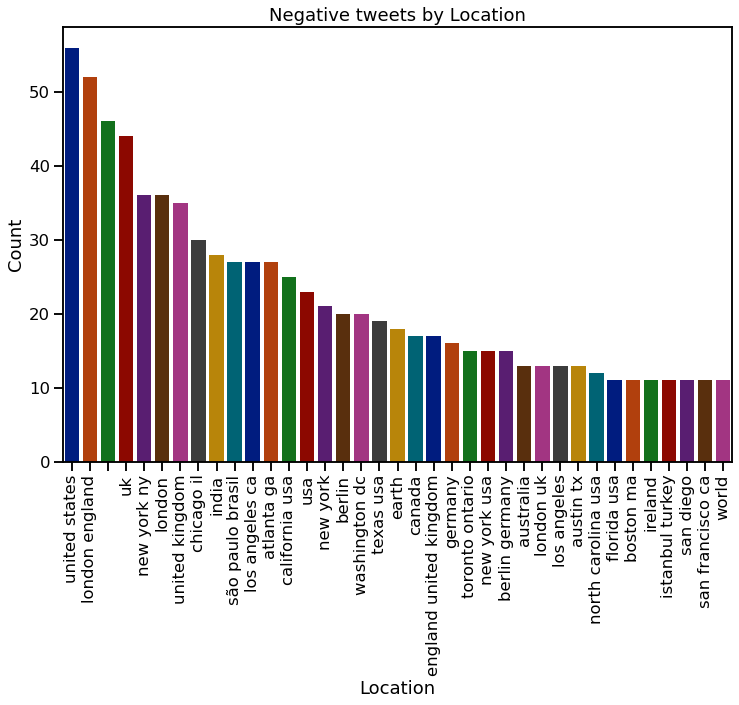

In [31]:
try:
    tweets_sentiment_negative_per_location=tweets_sentiment.groupby(['Location'])['Sentiment'].apply(lambda x: ((x=='Negative')==True).sum())
    tweets_sentiment_negative_per_location =tweets_sentiment_negative_per_location.to_frame() 
    tweets_sentiment_negative_per_location = tweets_sentiment_positive_per_location.sort_values(['Sentiment'],ascending=False).reset_index()
    tweets_sentiment_negative_per_location_old=tweets_sentiment_negative_per_location
    tweets_sentiment_negative_per_location=tweets_sentiment_negative_per_location.loc[tweets_sentiment_negative_per_location['Sentiment'] > 10]
    tweets_sentiment_negative_per_location=tweets_sentiment_negative_per_location[1:]
    plt.figure(figsize=(12,8))
    ax =sns.barplot(x=tweets_sentiment_negative_per_location['Location'],y=tweets_sentiment_negative_per_location.Sentiment,palette=sns.color_palette('dark'),saturation=1)
    ax.set(ylabel='Count')
    ax.set(xlabel='Location')
    ax.set(title="Negative tweets by Location")
    current_palette = sns.color_palette('dark')

    sns.set_context('talk')
    # sns.palplot(current_palette)
    sns.diverging_palette(255, 133, l=60, n=10, center="dark")
    ax.set_xticklabels(tweets_sentiment_negative_per_location.Location,rotation=90)
    fig = ax.get_figure()
    fig.savefig('tweets_sentiment_positive_per_geo.png',dpi=300, bbox_inches='tight')
except:
       print("Count of tweets is very less to show the image!!!")
       pass         

    Most negative tweets are from "{{tweets_sentiment_negative_per_location_old.Location[0]}}" followed by "{{tweets_sentiment_negative_per_location_old.Location[1]}}" and "{{tweets_sentiment_negative_per_location_old.Location[2]}}"

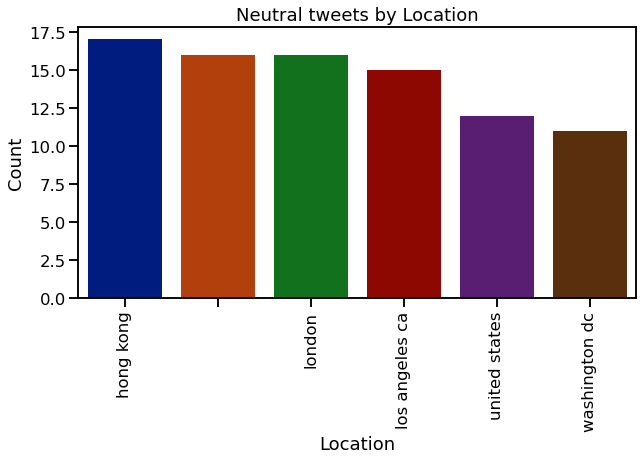

In [32]:
try:
    tweets_sentiment_neutral_per_location=tweets_sentiment.groupby(['Location'])['Sentiment'].apply(lambda x: ((x=='Neutral')==True).sum())
    tweets_sentiment_neutral_per_location =tweets_sentiment_neutral_per_location.to_frame() 
    tweets_sentiment_neutral_per_location = tweets_sentiment_neutral_per_location.sort_values(['Sentiment'],ascending=False).reset_index()
    tweets_sentiment_neutral_per_location_old=tweets_sentiment_neutral_per_location
    tweets_sentiment_neutral_per_location=tweets_sentiment_neutral_per_location.loc[tweets_sentiment_neutral_per_location['Sentiment'] > 10][:]
    tweets_sentiment_neutral_per_location=tweets_sentiment_neutral_per_location[1:]
    plt.figure(figsize=(10,5))
    ax =sns.barplot(x=tweets_sentiment_neutral_per_location['Location'],y=tweets_sentiment_neutral_per_location.Sentiment,palette=sns.color_palette('dark'),saturation=1)
    ax.set(ylabel='Count')
    ax.set(xlabel='Location')
    ax.set(title="Neutral tweets by Location")
    current_palette = sns.color_palette('dark')

    sns.set_context('talk')
    # sns.palplot(current_palette)
    sns.diverging_palette(255, 133, l=60, n=10, center="dark")
    ax.set_xticklabels(tweets_sentiment_neutral_per_location.Location,rotation=90)
    fig = ax.get_figure()
    fig.savefig('tweets_sentiment_neutral_per_location.png',dpi=300, bbox_inches='tight')
except: 
       print("Number of tweets are very less to show the image")
       pass

    Most of the neutral tweets came from "{{tweets_sentiment_neutral_per_location_old.Location[0]}}"  followed by "{{tweets_sentiment_neutral_per_location_old.Location[1]}}" and "{{tweets_sentiment_neutral_per_location_old.Location[2]}}"

## Percentage of Positive,Negative and Neutral tweets

In [33]:
vals=tweets_sentiment['Sentiment'].value_counts().to_frame()

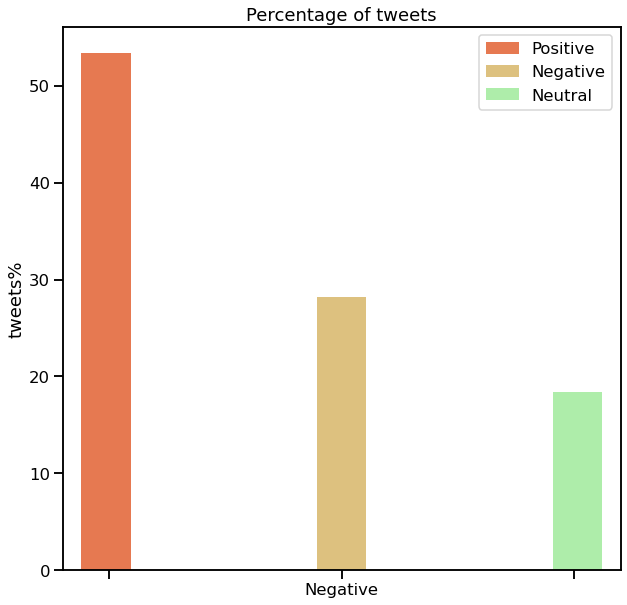

In [34]:
x_val=list(vals.index)
pd_df =(tweets_sentiment['Sentiment'].value_counts()*100/tweets_sentiment['Sentiment'].value_counts().sum()).to_frame()
x_val_c =[i[0] for i in pd_df.values]
plt.figure(figsize=(10,10))
ax =sns.barplot(x_val,x_val_c,hue=x_val,orient='v',palette=sns.color_palette('rainbow_r'),)
ax.set(ylabel='tweets%')
# ax.set(xticks=range(len(x_val)), xticklabels=x_val)
ax.set_xticks([-.25,1,2.25])
#ax.set(xlabel='Tweets')
ax.set(title="Percentage of tweets")
fig = ax.get_figure()
fig.savefig('tweets_sentiment_positive_per_geo1.png',dpi=300, bbox_inches='tight')

    It can be inferred that out of the total tweets "{{vals.iloc[0].name}}" contributes to the highest percentage followed by "{{vals.iloc[1].name}}" and "{{vals.iloc[2].name}}" tweets.

## Word Cloud


### Positive tweets Word Cloud

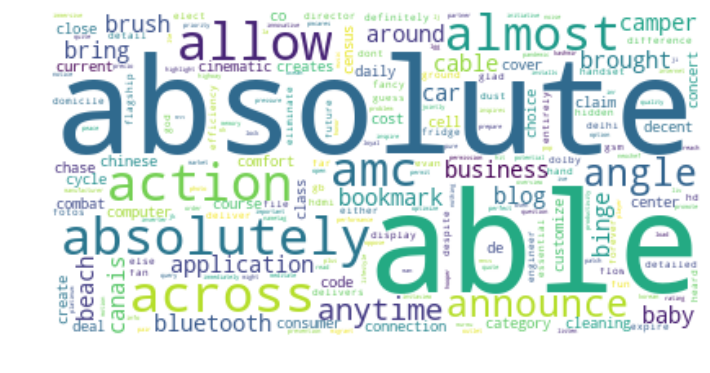

In [147]:
try:    
    tweets_sentiment_positive=tweets_sentiment[tweets_sentiment['Sentiment']=='Positive']
    new_doc=', '.join(tweets_sentiment_positive['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=2,max_df=10)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idf = vectorizer._tfidf.idf_
    d=dict(zip(vectorizer.get_feature_names(), idf))
    #print(d)



    wordcloud = WordCloud(stopwords='english',relative_scaling=0.1,background_color='White')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15,6) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("Wordcloud-Positive.png")
    plt.show()
except:
    print("Number of tweets is very less to display the wordcloud!!!")
    pass

### Negative tweets Word Cloud

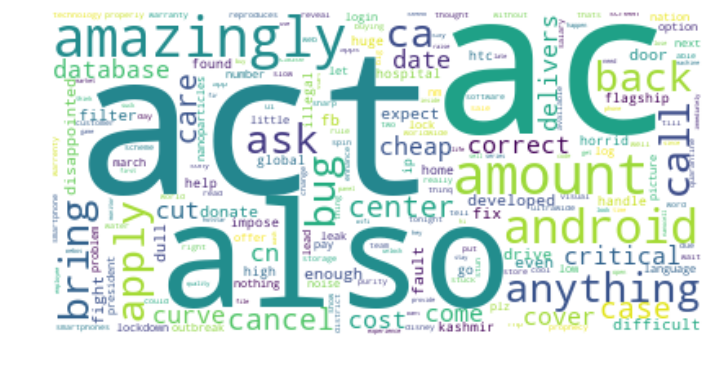

In [148]:
try:
    tweets_sentiment_positive=tweets_sentiment[tweets_sentiment['Sentiment']=='Negative']
    new_doc=', '.join(tweets_sentiment_positive['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=2,max_df=10)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idf = vectorizer._tfidf.idf_
    d=dict(zip(vectorizer.get_feature_names(), idf))
    #print(d)
    wordcloud = WordCloud(stopwords='english',relative_scaling=0.001,background_color='White')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15,6) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("Wordcloud-Negative.png")
    plt.show()
except:
       print("Number of tweets is very less to display the wordcloud!!!" )
       pass

In [149]:
try:
    tweets_sentiment_positive=tweets_sentiment[tweets_sentiment['Sentiment']=='Mixed']
    new_doc=', '.join(tweets_sentiment_positive['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=2,max_df=10)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idf = vectorizer._tfidf.idf_
    d=dict(zip(vectorizer.get_feature_names(), idf))
    #print(d)
    wordcloud = WordCloud(stopwords='english',relative_scaling=0.001,background_color='White')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15,6) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("Wordcloud-Negative.png")
    plt.show()
except:
       print("Number of tweets is very less to display the wordcloud!!!" )
       pass

Number of tweets is very less to display the wordcloud!!!


## Topic Modelling

### Topic Modelling on positive tweets

Topic 1: free,great,like,phone,india,work,thinq,home,stay,million
Topic 2: make,good,mount,enjoy,service,like,work,india,stay,please
Topic 3: care,lead,wash,oled,support,great,india,stay,phone,energy
Topic 4: kindly,since,lead,wroclaw,price,experience,service,free,work,chem
Topic 5: contact,enjoy,take,many,safe,know,chem,best,thinq,smart
Topic 6: make,chem,experience,take,good,enjoy,update,india,wash,loan
Topic 7: mount,good,oled,phone,india,like,great,support,home,wroclaw
Topic 8: know,many,mount,free,oled,best,great,home,thinq,poland
Topic 9: lead,well,experience,great,support,phone,work,home,stay,time
Topic 10: many,refrigerator,sound,take,oled,free,thinq,phone,home,help


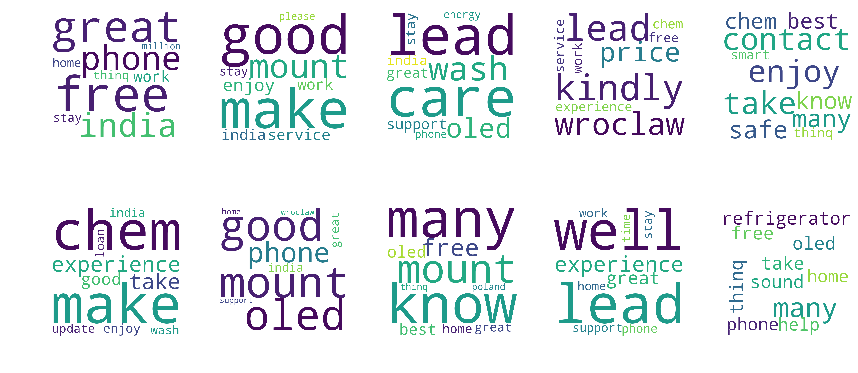

In [150]:
try:    
    tweets_sentiment_positive=tweets_sentiment.loc[tweets_sentiment['Sentiment']=='Positive']
    new_doc=', '.join(tweets_sentiment_positive['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens if len(w)>3])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=10,max_df=100)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idx_to_word = np.array(vectorizer.get_feature_names())

    # apply NMF
    nmf = NMF(n_components=10, solver="mu")
    W = nmf.fit_transform(X)
    H = nmf.components_
    # print the topics

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()


    for i, topic in enumerate(H):
        tupleList= ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])
        wordcloud = WordCloud(width=800, height=800, random_state=42,background_color="White").generate(tupleList)
        print("Topic {}: {}".format(i + 1,tupleList))
        axs[i].axis("off")
        axs[i].imshow(wordcloud)

        #print("Topic {}").format(i+1)
except:
    print("Number of tweets is very less to display the image!!!")

### Topic Modelling on negative tweets

Topic 1: give,refrigerator,please,small,support,brand,month,complaint,covid,service
Topic 2: employee,happen,please,complaint,month,small,brand,covid,never,know
Topic 3: work,file,pathetic,make,request,please,month,covid,refrigerator,color
Topic 4: life,hate,file,part,india,replace,give,support,complaint,request
Topic 5: available,india,oled,employee,color,hate,code,part,support,product
Topic 6: pathetic,take,people,product,happen,please,small,brand,never,work
Topic 7: part,india,happen,file,covid,month,small,brand,never,connect
Topic 8: connect,month,pathetic,hate,oled,covid,complaint,support,give,update
Topic 9: file,inch,code,pure,part,india,take,replace,refrigerator,issue
Topic 10: wash,start,hate,file,employee,never,support,give,complaint,year


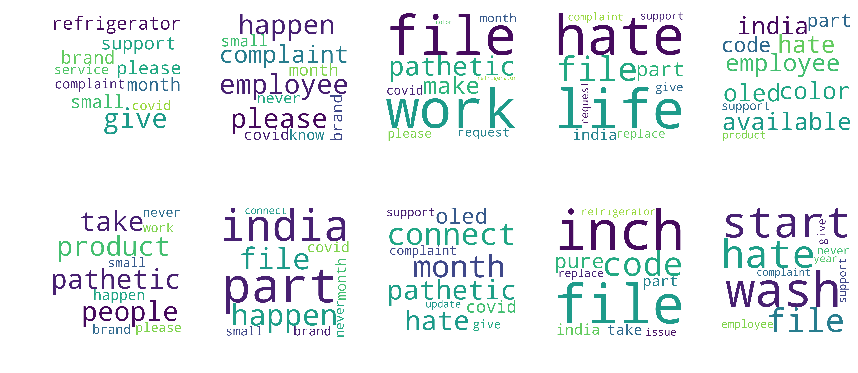

In [155]:
try:
    tweets_sentiment_negative=tweets_sentiment[tweets_sentiment['Sentiment']=='Negative']
    new_doc=', '.join(tweets_sentiment_negative['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens if len(w)>3])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=1,max_df=11)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idx_to_word = np.array(vectorizer.get_feature_names())

    # apply NMF
    nmf = NMF(n_components=10, solver="mu")
    W = nmf.fit_transform(X)
    H = nmf.components_
    # print the topics
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i, topic in enumerate(H):
        tupleList= ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])
        wordcloud = WordCloud(width=800, height=800, random_state=42,background_color="White").generate(tupleList)
        print("Topic {}: {}".format(i + 1,tupleList))
        axs[i].axis("off")
        axs[i].imshow(wordcloud)
except:
    print("Number of tweets very less to display the image!!!")
    pass

### Topic Modelling on neutral tweets

Topic 1: george,gen,gcam,gbon,gbe,gb,gather,generation,zee,samsung
Topic 2: generation,george,german,get,getyour,ghar,ghz,gim,gas,not
Topic 3: show,product,apps,make,try,work,buy,also,india,get
Topic 4: think,buy,back,try,even,time,still,india,go,tv
Topic 5: day,try,also,back,ultra,still,work,know,android,galaxy
Topic 6: try,think,day,india,app,time,even,still,android,phone
Topic 7: think,apps,later,buy,work,even,also,app,go,one
Topic 8: apps,later,plus,also,still,even,time,app,go,update
Topic 9: back,think,day,india,work,plus,need,know,android,use
Topic 10: come,back,plus,also,use,still,time,android,know,note


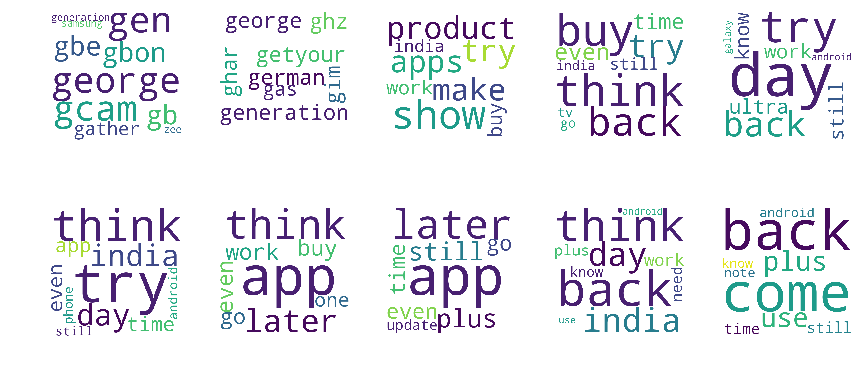

In [36]:
try:
    tweets_sentiment_neutral=tweets_sentiment.loc[tweets_sentiment['Sentiment']=='Neutral']
    new_doc=', '.join(tweets_sentiment_neutral['text'])
    filtered_sentence=[]
    word_tokens = word_tokenize(new_doc)
    filtered_sentence.append([w for w in word_tokens])
    #sents = nltk.sent_tokenize(filtered_sentence[0][0])
    vectorizer_list=[]
    vectorizer = TfidfVectorizer(min_df=1,max_df=100)
    X = vectorizer.fit_transform(filtered_sentence[0])
    idx_to_word = np.array(vectorizer.get_feature_names())

    # apply NMF
    nmf = NMF(n_components=10, solver="mu")
    W = nmf.fit_transform(X)
    H = nmf.components_
    # print the topics

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()


    for i, topic in enumerate(H):
        tupleList= ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])
        wordcloud = WordCloud(width=800, height=800, random_state=42,background_color='White').generate(tupleList)
        print("Topic {}: {}".format(i + 1,tupleList))
        axs[i].axis("off")
        axs[i].imshow(wordcloud)
        #axs[i].show()
except:
    print("Number of tweets very less to show the image")
    pass
